<a href="https://colab.research.google.com/github/lilyzhizhou/datathon-2/blob/main/%E2%80%9CDatathon_2_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Import libraries
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

In [50]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [56]:
# Upload Data
from google.colab import files
uploaded = files.upload()

Saving Cardiovascular Event Dataset.csv to Cardiovascular Event Dataset (2).csv


In [93]:
df_raw = pd.read_csv(io.BytesIO(uploaded['Cardiovascular Event Dataset.csv']))
df = df_raw.drop('id', axis = 1) # drops id variable
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [74]:
# Shape of the dataframe
print(df.shape)

# List the columns of the dataframe
print(df.columns)

# Look at unique values for each variable
for column in ['gender','ever_married','work_type','Residence_type','smoking_status']:
  print(f"{column} : {sorted(df[column].unique())}")

(5110, 11)
Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')
gender : ['Female', 'Male', 'Other']
ever_married : ['No', 'Yes']
work_type : ['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children']
Residence_type : ['Rural', 'Urban']
smoking_status : ['Unknown', 'formerly smoked', 'never smoked', 'smokes']


- 5110 total observations

### Data Exploration

In [75]:
description = df[['age','avg_glucose_level','bmi']].describe()
description = description.drop('count')
description

,age,avg_glucose_level,bmi
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


In [76]:
# Check for Na values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

- bmi is only variable that has missing values

In [94]:
# replace 0 with Nan for continuous variables
df[['age','avg_glucose_level','bmi']] = df[['age','avg_glucose_level','bmi']].replace(0, np.nan)

#check if missing values increased
df.isnull().sum()


gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

- How should we deal with missing bmi values?

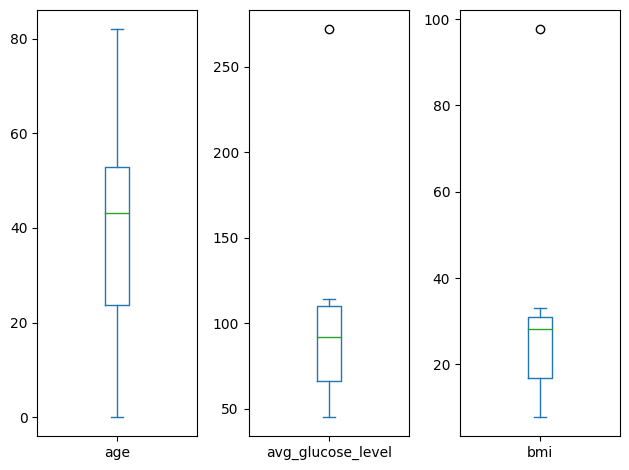

In [78]:
# Box plot of variables
description.plot(kind = 'box', subplots = True, layout = (1,3))
plt.tight_layout()
plt.show()

- look like there are some outliers for glucose_lb and bmi
- should consider removing?

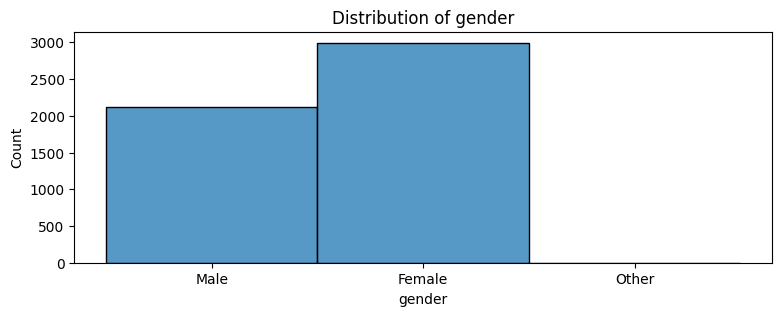

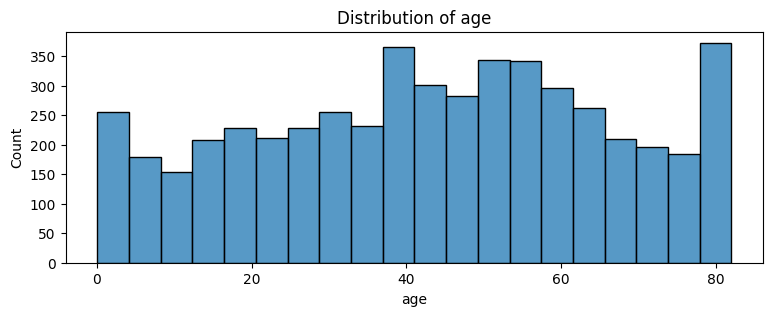

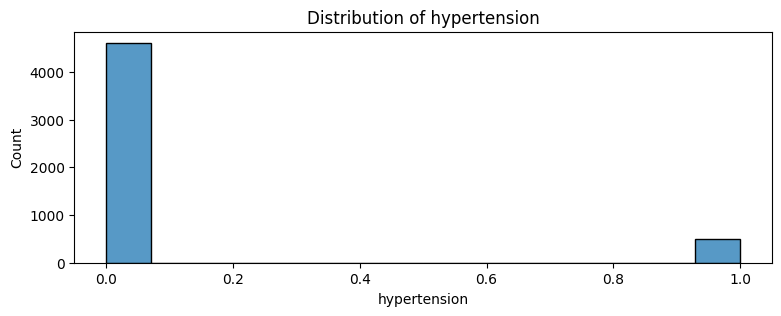

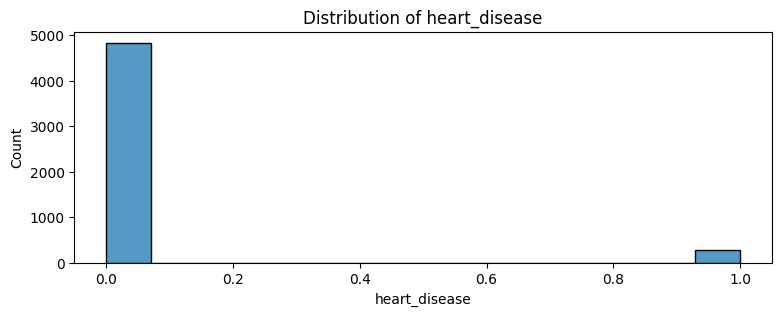

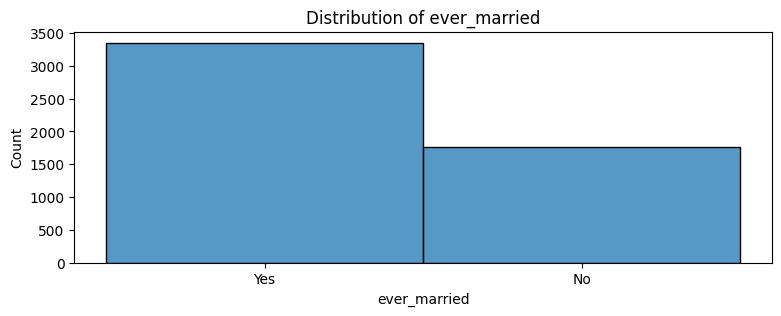

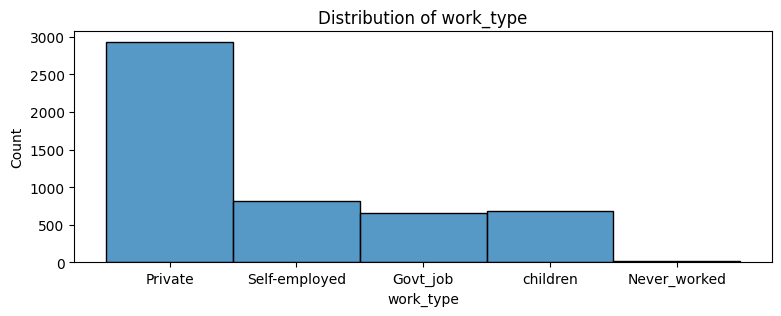

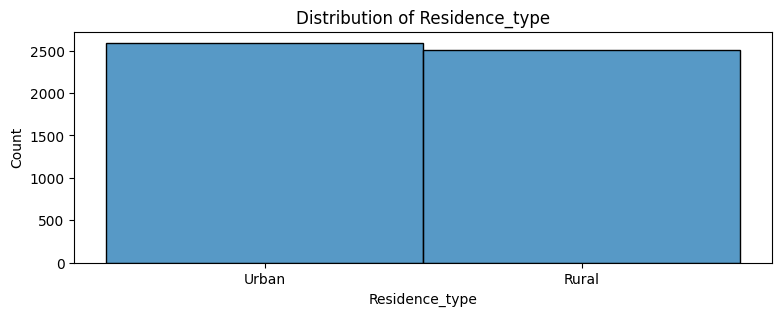

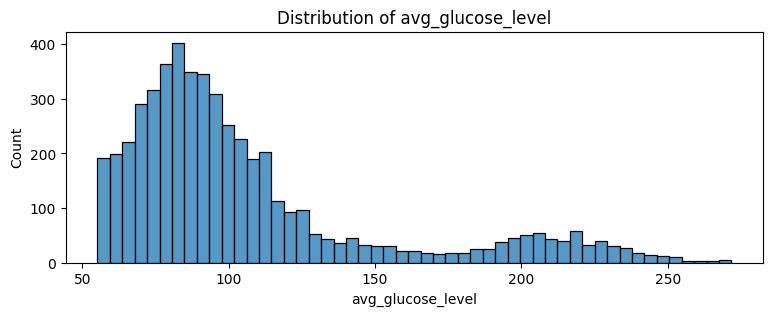

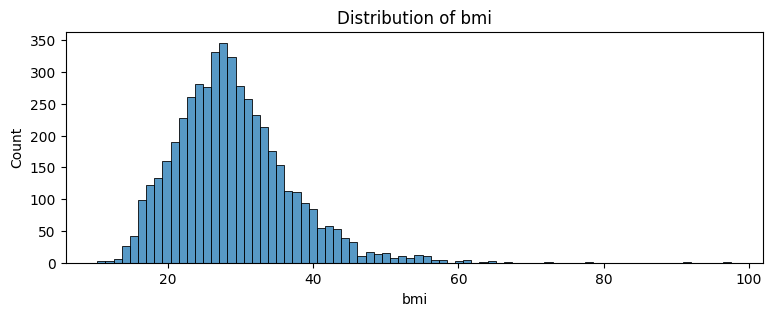

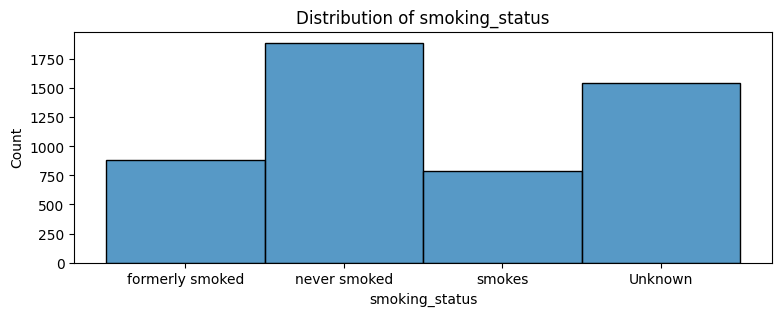

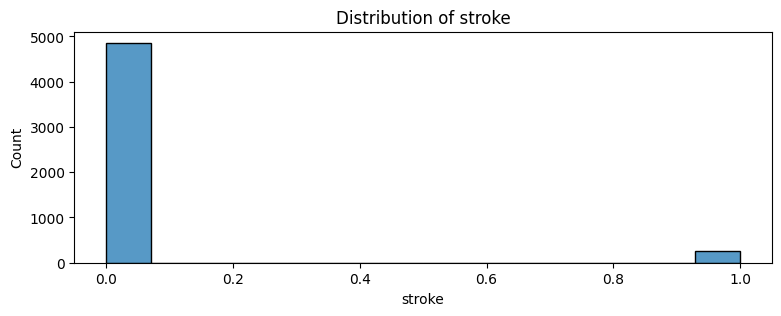

In [79]:
# Visualize histograms for all variables
for column in df.columns:
  plt.figure(figsize=(9, 3))
  sns.histplot(df[column], kde=False)
  plt.title(f'Distribution of {column}')
  plt.xlabel(column)
  plt.ylabel("Count")
  plt.show()


- should consider excluding observations where age is very young (if we're looking at preventable factors, early stroke would not apply to these people)

In [80]:
# tally number of observations for variables with uneven distribution
column = ['gender','hypertension','heart_disease','stroke']

count_table = pd.DataFrame({col: df[col].value_counts() for col in column})
print(count_table.round(0))

        gender  hypertension  heart_disease  stroke
0          NaN        4612.0         4834.0  4861.0
1          NaN         498.0          276.0   249.0
Female  2994.0           NaN            NaN     NaN
Male    2115.0           NaN            NaN     NaN
Other      1.0           NaN            NaN     NaN


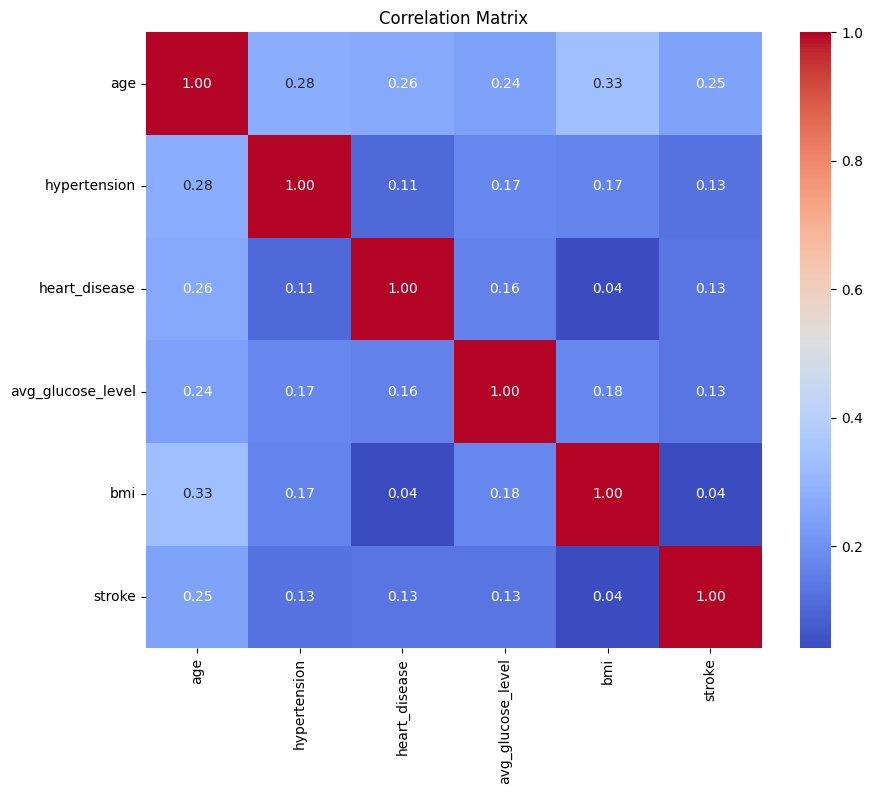

               age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4909.000000  5110.000000  
mean     28.893237     0.048728  
std       7.854067     0.215320  
min      10.300000     0.000000  
25%      23.500000     0.000000  
50%      28.100000     0.000000  
75%      33.100000     0.000000  
max      97.600000     1.000000  


In [81]:
# Correlation matrix to quantify relationships
#Identifying the Correlation Between Variables
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

# Summary statistics
summary_stats = df.describe()
print(summary_stats)

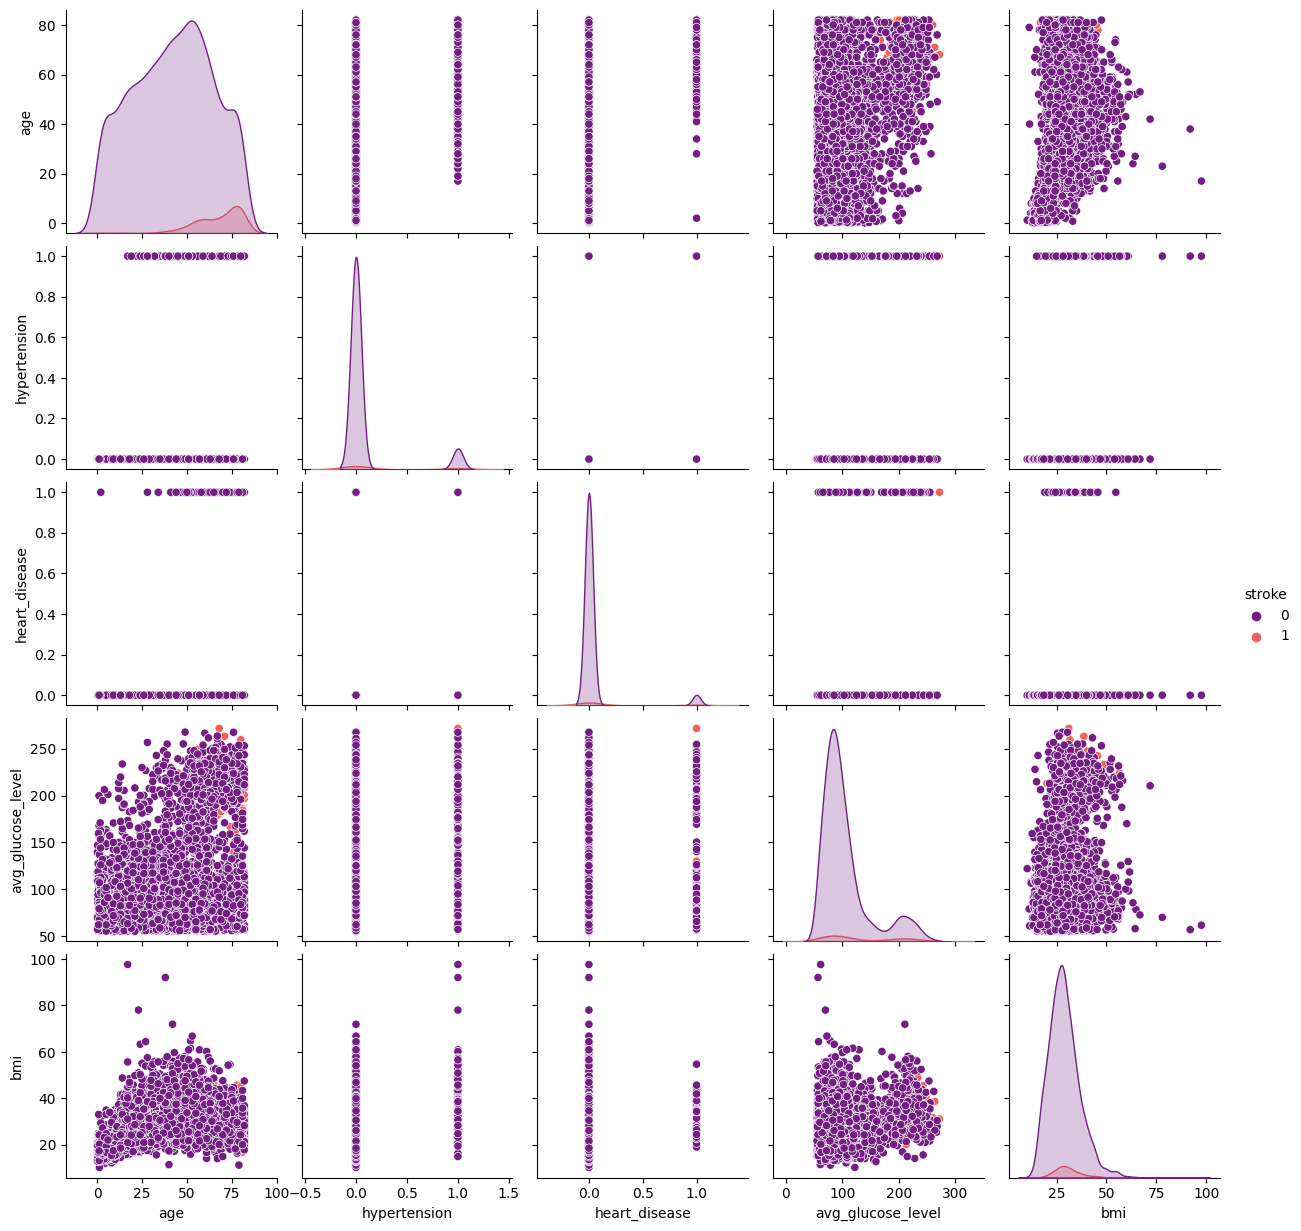

In [82]:
# Pair plot for data visualization
sns.pairplot(df, hue='stroke', palette="magma")
plt.show()

### Data Preparation

   gender   age  hypertension  heart_disease  ever_married  work_type  \
0     0.0  67.0             0              1             1          1   
1     1.0  61.0             0              0             1          1   
2     0.0  80.0             0              1             1          1   
3     1.0  49.0             0              0             1          1   
4     1.0  79.0             1              0             1          1   

   Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0               1             228.69  36.6               2       1  
1               0             202.21   NaN               1       1  
2               0             105.92  32.5               1       1  
3               1             171.23  34.4               3       1  
4               0             174.12  24.0               1       1  

any NaN values:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type      

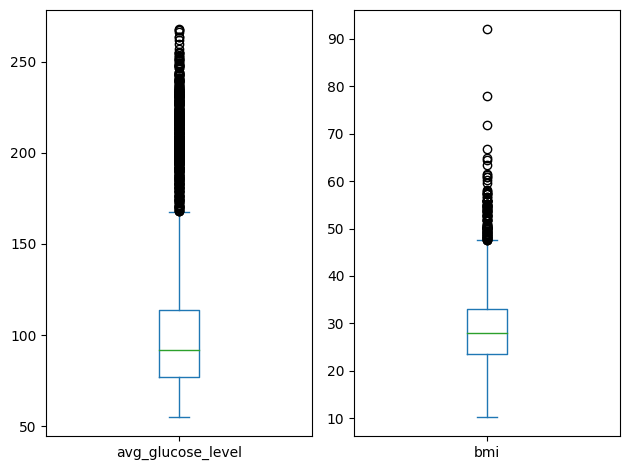

In [95]:
# Clean and filter data

# Encode gender variable
df['gender'] = df['gender'].replace({'Male':0, 'Female':1, 'Other': np.nan})
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1})
#work_type_mapping = {'Govt_job': 0, 'Never_worked': 1, 'Private': 2, 'Self-employed': 3, 'children': 4}
work_type_mapping = {'Govt_job': 1, 'Never_worked': 0, 'Private': 1, 'Self-employed': 1, 'children': 1}
df['work_type'] = df['work_type'].replace(work_type_mapping)
df['Residence_type'] = df['Residence_type'].replace({'Rural': 0, 'Urban': 1})
#smoking_status_mapping = {'Unknown': 0, 'formerly smoked': 1, 'never smoked': 2, 'smokes': 3}
smoking_status_mapping = {'Unknown': 0, 'never smoked': 1, 'formerly smoked': 2,'smokes': 3}
df['smoking_status'] = df['smoking_status'].replace(smoking_status_mapping)

print(df.head())

# restrict age
#df = df[df['age'] >= 45] # def stroke for young people < 45 "https://stanfordhealthcare.org/content/dam/SHC/clinics/stroke-center/docs/stroke-young-patients-qa.pdf"

# replace outliers from bmi and glucose variable with NaN
df['avg_glucose_level'] = df['avg_glucose_level'].replace(271.74, np.nan)
df['bmi'] = df['bmi'].replace(97.6, np.nan)

# drop missing NaN values including missing bmi ones
df = df.dropna()

print('\nany NaN values:')
print(df.isnull().sum())
print('\n# of observations:')
print(df.shape)

# plot out bmi and glucose
print('\nbox-plot')
df[['avg_glucose_level','bmi']].plot(kind = 'box', subplots = True, layout = (1,2))
plt.tight_layout()
plt.show()

- total number of observations have been cut by half (2443) after removal of NaN
- considering what other options to use to deal with missing bmi values?
- decided not to remove outliers given distribution of data

In [103]:
# 1. Split data into predictor and outcome variable
X = df.drop('stroke', axis = 1)
y = df['stroke']

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### Building Logistic Regression Model

In [104]:
# Training logistic regression model
log_reg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear') # need to decide if l1 or l2 is better
log_reg.class_weight="balanced" # added weight based on class size given small cell size for stroke
log_reg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', solver='liblinear')

In [106]:
# Training Model + Evaluation

# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[683 246]
 [ 10  43]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.84       929
           1       0.15      0.81      0.25        53

    accuracy                           0.74       982
   macro avg       0.57      0.77      0.55       982
weighted avg       0.94      0.74      0.81       982



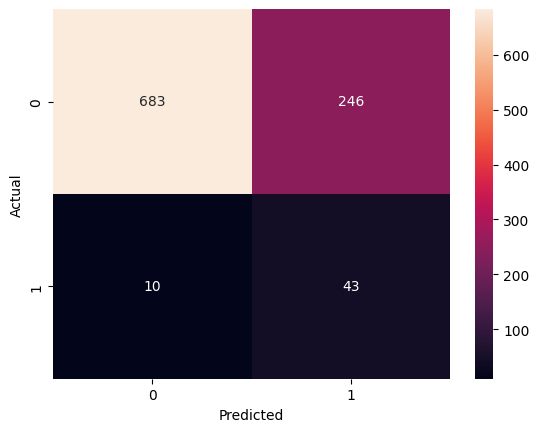

In [107]:
# Confusion Matrix heat map
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Model Diagnostics

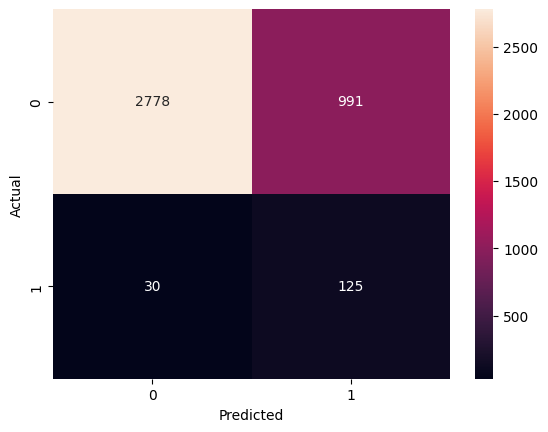

In [108]:
#Comparing training error and testing error
# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_train)

# Evaluate the model
conf_matrix = confusion_matrix(y_train, y_pred)
class_report = classification_report(y_train, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [100]:
# Model Summary

# Separate features and target variable
X = df.drop('stroke', axis=1)
y = df['stroke']

# Add a constant term for the intercept
X = sm.add_constant(X)

# Create and fit logistic regression model
log_reg = sm.Logit(y, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

         Current function value: 0.139365
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 4906
Model:                          Logit   Df Residuals:                     4895
Method:                           MLE   Df Model:                           10
Date:                Sun, 01 Oct 2023   Pseudo R-squ.:                  0.2058
Time:                        16:21:14   Log-Likelihood:                -683.72
converged:                      False   LL-Null:                       -860.95
Covariance Type:            nonrobust   LLR p-value:                 4.530e-70
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -20.0728   1970.183     -0.010      0.992   -3881.560    3841.414
gender                0.0216      0.154     

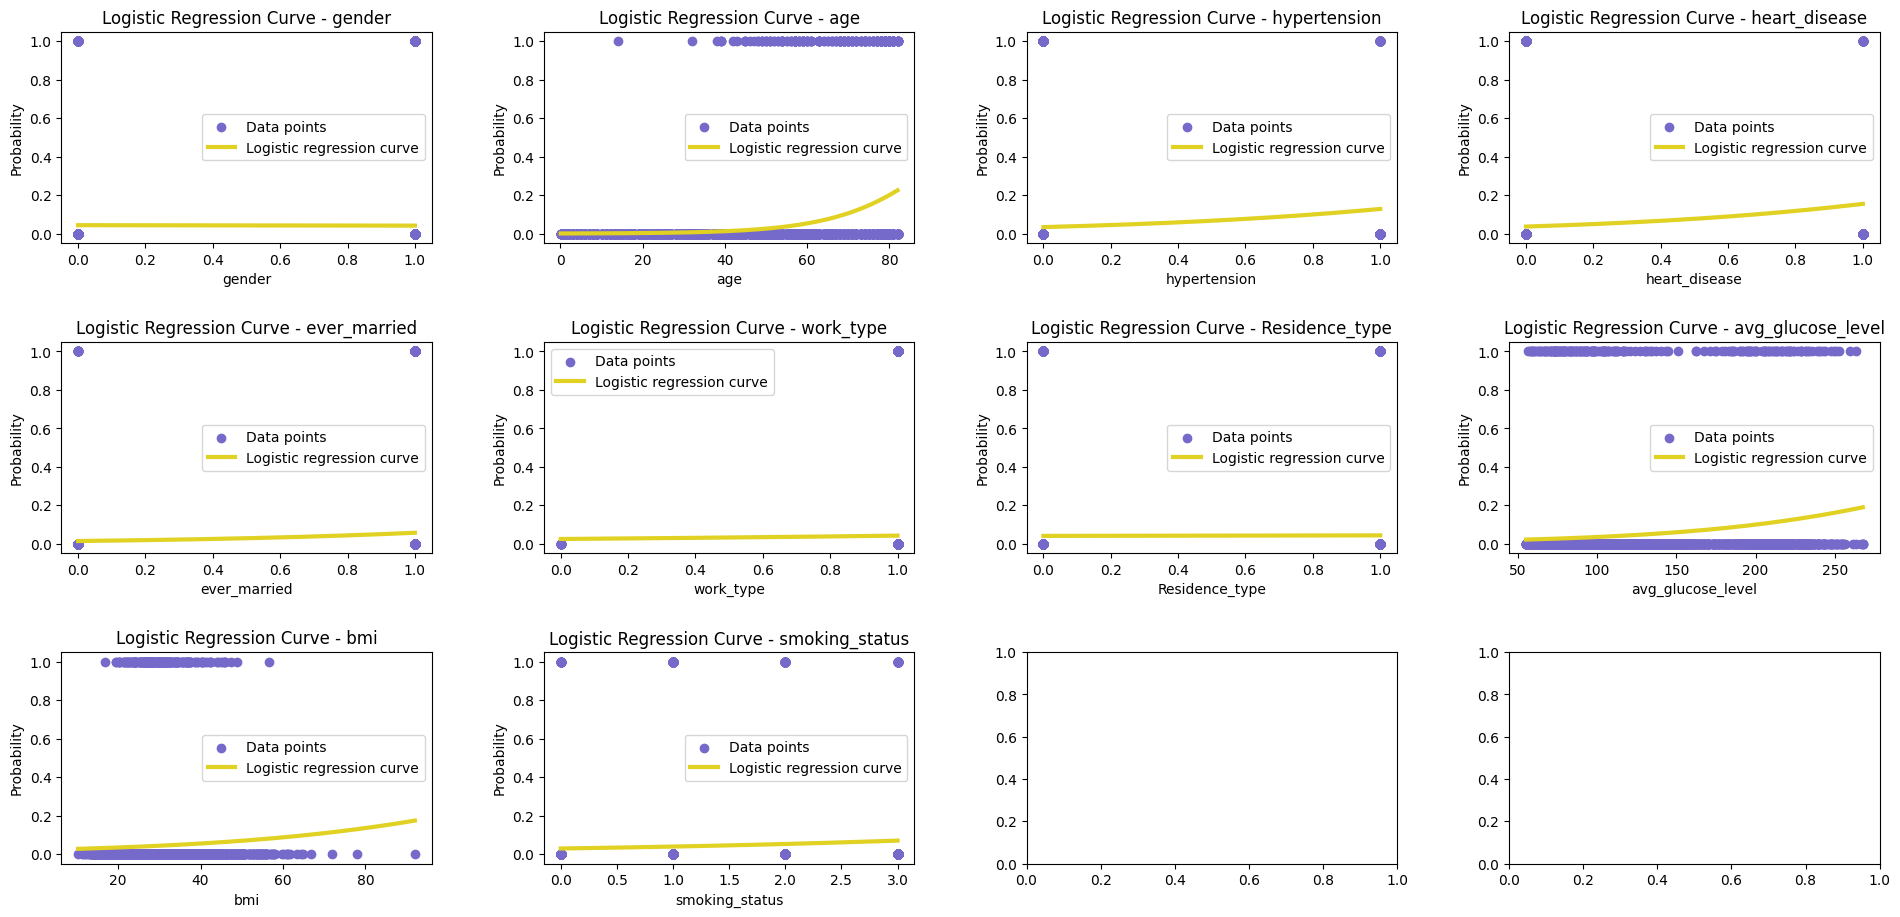

In [101]:
# Create logistic regression object
log_reg = LogisticRegression()

fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.tight_layout(pad=5.0)  # Adds padding between subplots

for i, feature in enumerate(df.columns[:-1]):  # Exclude 'Outcome' column
    row = i // 4  # Determine row index
    col = i % 4   # Determine column index

    # Reshape the feature and outcome arrays to fit the model
    X = df[[feature]]
    y = df['stroke']

    # Fit logistic regression model
    log_reg.fit(X, y)

    # Get min and max values of the feature for plotting
    x_test = np.linspace(X.min(), X.max(), 300)

    # Get the probability for each value in the range
    prob = log_reg.predict_proba(x_test)[:, 1]

    # Plot the data points
    axs[row, col].scatter(X, y, color='#7569c9', label='Data points')

    # Plot the sigmoid curve
    axs[row, col].plot(x_test, prob, color='#e0d122', lw=3, label='Logistic regression curve' )

    axs[row, col].set_title(f'Logistic Regression Curve - {feature}')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Probability')
    axs[row, col].legend()

plt.show()